# ML models assessment

### Import libraries

In [20]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.dummy import DummyRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

### Import dataset

In [21]:
data = pd.read_csv('../../datasets/data-stemmed.csv')
data.info()
nan_count = data['processed text'].isnull().sum()
print(f'Number of NaN values: {nan_count}') # 2 NaN values (non so il perchè, nel file di stemming non uscivano)
print(f'Number of rows: {len(data)}')
data = data.dropna(subset=['processed text'])
print(f'Number of rows after dropping NaN values: {len(data)}')
data.head(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4979 entries, 0 to 4978
Data columns (total 17 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   text                 4977 non-null   object 
 1   quotes               4979 non-null   int64  
 2   is.retweet           4979 non-null   bool   
 3   external.link        4979 non-null   bool   
 4   pictures             4979 non-null   bool   
 5   videos               4979 non-null   bool   
 6   gifs                 4979 non-null   bool   
 7   multimedial_content  4979 non-null   bool   
 8   user.image           4979 non-null   bool   
 9   user.bio             4979 non-null   bool   
 10  user.website         4979 non-null   bool   
 11  user.tweets          4979 non-null   int64  
 12  user.following       4979 non-null   int64  
 13  user.media           4979 non-null   int64  
 14  engagement.rate      4979 non-null   float64
 15  n_hashtags           4979 non-null   i

,text,quotes,is.retweet,external.link,pictures,videos,gifs,multimedial_content,user.image,user.bio,user.website,user.tweets,user.following,user.media,engagement.rate,n_hashtags,processed text
0,Fried Chicken with Hot 🔥 Sauce Corn Muffin and...,1,True,False,True,False,False,True,True,True,True,16213,549,15698,0.571817,8,fri chicken hot fire sauc corn muffin season f...
1,#Morel #mushrooms at center of #food #poisonin...,0,False,False,False,False,False,False,True,True,True,50098,513,1962,0.000000,10,morel mushroom center food poison outbreak fun...
2,My Blog:: Obama Legacy Facing REVISIT ... Ian...,0,False,False,False,False,False,False,True,True,True,5174,9022,0,0.008527,11,blog obama legaci face revisit ianrmackintoshb...
3,Craving sushi but tired of expensive takeout? ...,0,False,False,False,False,False,False,True,True,True,108071,678,49647,0.000000,6,crave sushi tire expens takeout look kellylov ...
4,Potato Pancakes should not be a rare side dish...,0,False,False,True,False,False,True,True,True,True,28081,2343,18032,0.000000,8,potato pancak rare side dish plan leftov time ...


### Perform vectrorization

Perform here the division between covariates and target variable in order to easen the code later on

In [22]:
data.drop(['text'], axis=1, inplace=True)
Y = data['engagement.rate']
data['engagement.rate'].fillna(data['engagement.rate'].mean(), inplace=True)
X = data.drop(columns=['engagement.rate'])
X.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4977 entries, 0 to 4978
Data columns (total 15 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   quotes               4977 non-null   int64 
 1   is.retweet           4977 non-null   bool  
 2   external.link        4977 non-null   bool  
 3   pictures             4977 non-null   bool  
 4   videos               4977 non-null   bool  
 5   gifs                 4977 non-null   bool  
 6   multimedial_content  4977 non-null   bool  
 7   user.image           4977 non-null   bool  
 8   user.bio             4977 non-null   bool  
 9   user.website         4977 non-null   bool  
 10  user.tweets          4977 non-null   int64 
 11  user.following       4977 non-null   int64 
 12  user.media           4977 non-null   int64 
 13  n_hashtags           4977 non-null   int64 
 14  processed text       4977 non-null   object
dtypes: bool(9), int64(5), object(1)
memory usage: 315.9+ KB


In [23]:
# label encoding
# max_df will be set with regard of the best parameter found in the previous step
vectorizer = TfidfVectorizer(max_df=0.80) # ignore terms that appear in more than 80% of the documents

dtm = vectorizer.fit_transform(X['processed text'])
# DTM is a document-term matrix with shape (n_samples, n_features) having as rows the documents and as columns the terms learned as vocabulary
# The value of each cell is the tf-idf score

# Convert sparse matrix to dense matrix
dense_matrix = dtm.toarray()

# Display non-zero elements
non_zero_elements = dense_matrix[dense_matrix != 0]
print(len(non_zero_elements))
print(non_zero_elements)

# Convert the DTM to a dataframe
dtm_df = pd.DataFrame(dtm.toarray(), columns=vectorizer.get_feature_names_out())

# Merge the two dataframes
# Reset the indexes of both X and dtm_df
X.reset_index(drop=True, inplace=True)
dtm_df.reset_index(drop=True, inplace=True)

# Concatenate the DataFrames
merged_df = pd.concat([X, dtm_df], axis=1)
X.fillna(0, inplace=True)
flag=False
if 'engagement.rate' in X.columns:
    flag = True
print(f'{flag}')
X.head(5)

81923
[0.17888055 0.27323178 0.2068867  ... 0.24840258 0.86291552 0.5053482 ]
False


,quotes,is.retweet,external.link,pictures,videos,gifs,multimedial_content,user.image,user.bio,user.website,user.tweets,user.following,user.media,n_hashtags,processed text
0,1,True,False,True,False,False,True,True,True,True,16213,549,15698,8,fri chicken hot fire sauc corn muffin season f...
1,0,False,False,False,False,False,False,True,True,True,50098,513,1962,10,morel mushroom center food poison outbreak fun...
2,0,False,False,False,False,False,False,True,True,True,5174,9022,0,11,blog obama legaci face revisit ianrmackintoshb...
3,0,False,False,False,False,False,False,True,True,True,108071,678,49647,6,crave sushi tire expens takeout look kellylov ...
4,0,False,False,True,False,False,True,True,True,True,28081,2343,18032,8,potato pancak rare side dish plan leftov time ...


Drop the text column, as processed text will be the covariate of interest.
Then perform the X, Y division, where Y will be engagement rate

In [24]:
X.drop(columns=['processed text'], inplace=True)
X.head(5)

,quotes,is.retweet,external.link,pictures,videos,gifs,multimedial_content,user.image,user.bio,user.website,user.tweets,user.following,user.media,n_hashtags
0,1,True,False,True,False,False,True,True,True,True,16213,549,15698,8
1,0,False,False,False,False,False,False,True,True,True,50098,513,1962,10
2,0,False,False,False,False,False,False,True,True,True,5174,9022,0,11
3,0,False,False,False,False,False,False,True,True,True,108071,678,49647,6
4,0,False,False,True,False,False,True,True,True,True,28081,2343,18032,8


In [25]:
# dataframe for storing results in a convenient way for shwing boxplot later
reg_metrics = pd.DataFrame(columns=['Model', 'MAE', 'MSE', 'MAPE'])

### Dummy regressor

We are going to use a dummy regressor (that estimates the mean of the output variable) as a baseline.

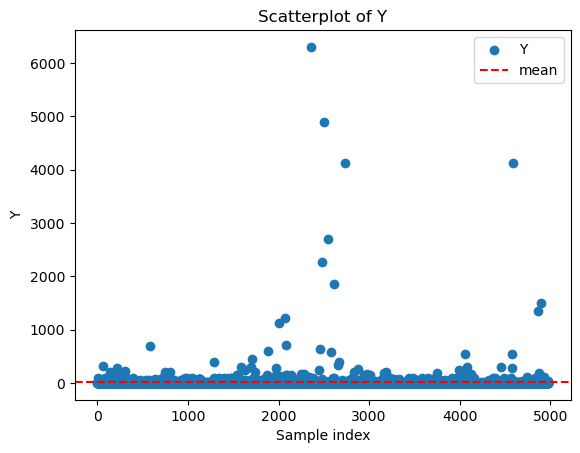

MSE Scores: 0     114578.213091
1       7654.427470
2        898.732090
3      17001.910920
4       1030.618603
5        300.477919
6       3864.829594
7      11004.587943
8      42333.136240
9      53764.551103
10     82357.046193
11     38722.840513
12       756.904541
13      8897.621003
14      1564.803322
15      2254.972800
16      2771.407240
17     95195.311002
18     19061.317494
19       863.815301
Name: MSE, dtype: float64
Mean MSE: 25243.876219079233


In [27]:
dummy_kfolds = KFold(n_splits=10, shuffle=True)
for train_idx, test_idx in dummy_kfolds.split(X):
  dummy_regressor = DummyRegressor()
  dummy_regressor.fit(X.iloc[train_idx], Y.iloc[train_idx])
  y_dummy_reg = dummy_regressor.predict(X.iloc[test_idx])
  current_dummy_mae = mean_absolute_error(Y.iloc[test_idx], y_dummy_reg)
  current_dummy_mse = mean_squared_error(Y.iloc[test_idx], y_dummy_reg)
  current_dummy_mape = mean_absolute_percentage_error(Y.iloc[test_idx], y_dummy_reg)
  reg_metrics.loc[len(reg_metrics)] = ['DUMMY', current_dummy_mae, current_dummy_mse, current_dummy_mape]

#Scatterplot of Y
mean_y = np.mean(Y)
plt.scatter(np.arange(len(Y)), Y, label='Y')
plt.axhline(y=mean_y, color='r', linestyle='--', label='mean')    # Plot the mean
plt.title('Scatterplot of Y')
plt.xlabel('Sample index')
plt.ylabel('Y')
plt.legend()
plt.show()

# Print MSE scores and mean MSE
print(f"MSE Scores: {reg_metrics.loc[reg_metrics['Model']=='DUMMY','MSE']}")
print(f"Mean MSE: {np.mean(reg_metrics.loc[reg_metrics['Model']=='DUMMY','MSE'])}")

We can see that the dummy classifier doesn't do much, as with few outliers, but that generates much leverage, the MSE is indeed very high

## Single decision tree

In [28]:
# Decision Tree Regressor
# Initialize a decision tree regressor instance
tree_kfolds = KFold(n_splits=10, shuffle=True)
for train_idx, test_idx in tree_kfolds.split(X):
  rf_regressor = DecisionTreeRegressor()
  rf_regressor.fit(X.iloc[train_idx], Y.iloc[train_idx])
  y_tree_reg = rf_regressor.predict(X.iloc[test_idx])
  current_tree_mae = mean_absolute_error(Y.iloc[test_idx], y_tree_reg)
  current_tree_mse = mean_squared_error(Y.iloc[test_idx], y_tree_reg)
  current_tree_mape = mean_absolute_percentage_error(Y.iloc[test_idx], y_tree_reg)
  reg_metrics.loc[len(reg_metrics)] = ['TREE', current_tree_mae, current_tree_mse, current_tree_mape]

# Print MSE scores and mean MSE
print(f"MSE Scores: {reg_metrics.loc[reg_metrics['Model']=='TREE','MSE']}")
print(f"Mean MSE: {np.mean(reg_metrics.loc[reg_metrics['Model']=='TREE','MSE'])}")

MSE Scores: 20    87042.882809
21    13158.415859
22     8131.735783
23    57013.787222
24     8711.479027
25    78015.049821
26    37727.022174
27    82032.117980
28    36986.556255
29     4185.123199
Name: MSE, dtype: float64
Mean MSE: 41300.41701289942


## RandomForest

In [29]:
# Random Forest Regressor
# Initialize a random forest regressor instance
rf_kfolds = KFold(n_splits=10, shuffle=True)
for train_idx, test_idx in rf_kfolds.split(X):
  rf_regressor = RandomForestRegressor()
  rf_regressor.fit(X.iloc[train_idx], Y.iloc[train_idx])
  y_rf_reg = rf_regressor.predict(X.iloc[test_idx])
  current_rf_mae = mean_absolute_error(Y.iloc[test_idx], y_rf_reg)
  current_rf_mse = mean_squared_error(Y.iloc[test_idx], y_rf_reg)
  current_rf_mape = mean_absolute_percentage_error(Y.iloc[test_idx], y_rf_reg)
  reg_metrics.loc[len(reg_metrics)] = ['RF', current_rf_mae, current_rf_mse, current_rf_mape]
     

# Print MSE scores and mean MSE
print(f"MSE Scores: {reg_metrics.loc[reg_metrics['Model']=='RF','MSE']}")
print(f"Mean MSE: {np.mean(reg_metrics.loc[reg_metrics['Model']=='RF','MSE'])}")

MSE Scores: 30     4469.949323
31     7539.378012
32    57248.430723
33    61378.960686
34    27152.406160
35    96138.443546
36     1613.644924
37     6138.105154
38     7045.376331
39     3397.550942
Name: MSE, dtype: float64
Mean MSE: 27212.224580050457


## SVM

In [30]:
sv_kfolds = KFold(n_splits=10, shuffle=True)
for train_idx, test_idx in sv_kfolds.split(X):
  sv_regressor = SVR()
  sv_regressor.fit(X.iloc[train_idx], Y.iloc[train_idx])
  y_sv_reg = sv_regressor.predict(X.iloc[test_idx])
  current_sv_mae = mean_absolute_error(Y.iloc[test_idx], y_sv_reg)
  current_sv_mse = mean_squared_error(Y.iloc[test_idx], y_sv_reg)
  current_sv_mape = mean_absolute_percentage_error(Y.iloc[test_idx], y_sv_reg)
  reg_metrics.loc[len(reg_metrics)] = ['SVM', current_sv_mae, current_sv_mse, current_sv_mape]

# Print MSE scores and mean MSE
print(f"MSE Scores: {reg_metrics.loc[reg_metrics['Model']=='SVM','MSE']}")
print(f"Mean MSE: {np.mean(reg_metrics.loc[reg_metrics['Model']=='SVM','MSE'])}")

MSE Scores: 40    37439.132870
41      771.360936
42     1403.031206
43    80862.058838
44     1652.217071
45    40216.677990
46    56656.808858
47     5095.538060
48    11092.105747
49    18659.716325
Name: MSE, dtype: float64
Mean MSE: 25384.864790009007


## kNearestNeighbor

In [31]:
knn_kfolds = KFold(n_splits=10, shuffle=True)
for train_idx, test_idx in knn_kfolds.split(X):
  knn_regressor = KNeighborsRegressor()
  knn_regressor.fit(X.iloc[train_idx], Y.iloc[train_idx])
  y_knn_reg = knn_regressor.predict(X.iloc[test_idx])
  current_knn_mae = mean_absolute_error(Y.iloc[test_idx], y_knn_reg)
  current_knn_mse = mean_squared_error(Y.iloc[test_idx], y_knn_reg)
  current_knn_mape = mean_absolute_percentage_error(Y.iloc[test_idx], y_knn_reg)
  reg_metrics.loc[len(reg_metrics)] = ['KNN', current_knn_mae, current_knn_mse, current_knn_mape]

# Print MSE scores and mean MSE
print(f"MSE Scores: {reg_metrics.loc[reg_metrics['Model']=='KNN','MSE']}")
print(f"Mean MSE: {np.mean(reg_metrics.loc[reg_metrics['Model']=='KNN','MSE'])}")

MSE Scores: 50     9215.117903
51     6262.007019
52    61159.736493
53    22901.865778
54    19838.881836
55    71912.462581
56     9630.467998
57    14201.239202
58     7654.181841
59    86995.316985
Name: MSE, dtype: float64
Mean MSE: 30977.127763541484


## Some plots

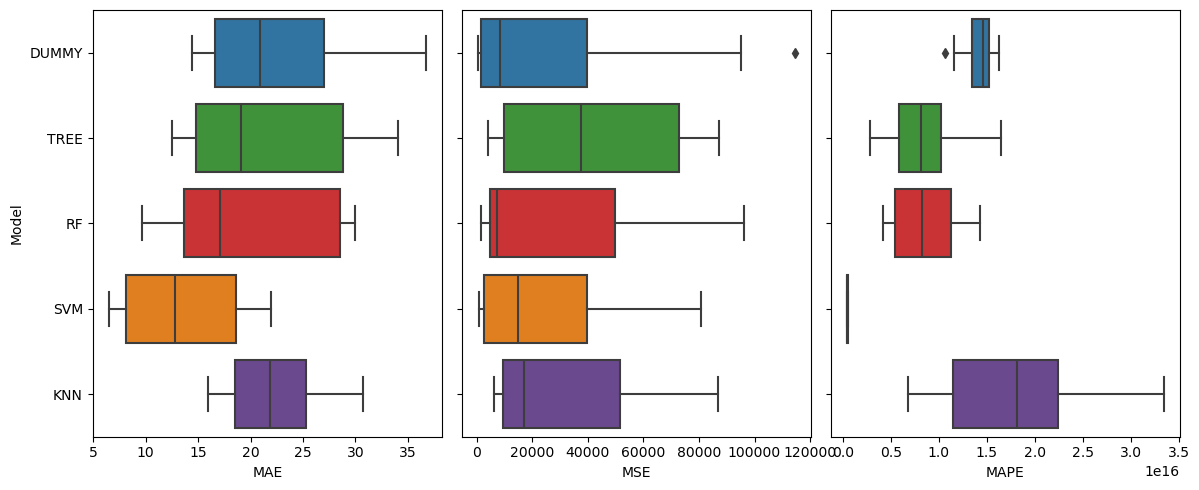

In [32]:
fig, axs = plt.subplots(1, 3, figsize=(12, 5))
sns.boxplot(data=reg_metrics, x="MAE", y="Model", ax=axs[0], palette=sns.color_palette('Paired')[1::2])
sns.boxplot(data=reg_metrics, x="MSE", y="Model", ax=axs[1], palette=sns.color_palette('Paired')[1::2])
axs[1].set_yticklabels('')
axs[1].set_ylabel('')
sns.boxplot(data=reg_metrics, x="MAPE", y="Model", ax=axs[2], palette=sns.color_palette('Paired')[1::2])
axs[2].set_yticklabels('')
axs[2].set_ylabel('')
plt.tight_layout()
plt.show()